

---


# **1. Setting up the environment**


---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing the required modules:**
- python-dotenv
- langchain
- langchain-google-genai
- langchain_community
- langgraph
- grandalf
- langsmith
- tavily-python

In [2]:
%pip install -r '/content/drive/MyDrive/LangGraph/Customer_Service_Chatbot/requirements.txt' --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB

**Loading the environment variables:**

In [3]:
from dotenv import load_dotenv
load_dotenv("/content/drive/MyDrive/LangGraph/Customer_Service_Chatbot/chat_key.txt", override=True)

True

**Initializing the LLM:**

In [4]:
%pip install langchain_openai --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 957.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 17.4 MB/s eta 0:00:00


In [5]:
from langchain_openai import ChatOpenAI
llm= ChatOpenAI()



---


#**2. Defining the tool**


---



In [6]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

from google.auth import default
CREDENTIALS, _ = default()

PROJECT_ID= "basic-pipeline-435315"
REGION= "us-central1"

Authenticated


In [7]:
import re
import numpy as np

from google.cloud import bigquery
bq_client= bigquery.Client(
    project=PROJECT_ID,
    credentials=CREDENTIALS)

In [8]:
query_info="""
SELECT *
FROM
 `basic-pipeline-435315.Hotel_reviews.europe_reviews`
LIMIT 10
"""
job= bq_client.query(query_info)

In [9]:
hotel_info= job.result().to_arrow().to_pandas()
hotel_info.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [70]:
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from typing import Optional, List, Dict
from google.cloud import bigquery

@tool
def Search_hotels(
    config: RunnableConfig,
    Address: Optional[str] = None,
    Name: Optional[str] = None,
    Avg_score: Optional[float] = None,
    Tag: Optional[str] = None
    ) -> List[Dict]:
    """
    Search for hotels based on the provided criteria.

    Args:
      Address: The address of the hotel.
      Name: The name of the hotel.
      Avg_score: The average score of the hotel.
      Tag: The tag of the hotel such as business, couples, etc.

    Returns:
      List[Dict]: A list of hotel dictionaries matching the search criteria.
    """
    configuration = config.get("configurable", {})
    rev_nationality = configuration.get("Reviewer_Nationality", None)
    if not rev_nationality:
        raise ValueError("No Reviewer_Nationality configured.")

    # Base query
    query = """
    SELECT Hotel_Name, Hotel_Address, Average_Score, Tags
    FROM `basic-pipeline-435315.Hotel_reviews.europe_reviews`
    WHERE 1=1
    """
    params = []

    if Address:
        query += " AND Hotel_Address LIKE @Address"
        params.append(bigquery.ScalarQueryParameter("Address", "STRING", f"%{Address}%"))
    if Name:
        query += " AND Hotel_Name LIKE @Name"
        params.append(bigquery.ScalarQueryParameter("Name", "STRING", f"%{Name}%"))
    if Avg_score is not None:
        query += " AND Average_Score >= @Avg_score"
        params.append(bigquery.ScalarQueryParameter("Avg_score", "FLOAT64", Avg_score))
    if Tag:
        query += " AND Tags LIKE @Tag"
        params.append(bigquery.ScalarQueryParameter("Tag", "STRING", f"%{Tag}%"))

    query+= """
    LIMIT 10
    """
    job = bq_client.query(query, job_config=bigquery.QueryJobConfig(
        query_parameters=params
    ))

    # Converting to list of dicts
    results = job.result()
    hotels = [dict(row) for row in results]

    return hotels

**Utility fucntions:**

In [31]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode

def tool_handles(state) -> dict:
  """
  Handles the tool errors during execution.
  """
  err= state.get('error')
  tool_calls= state["messages"][-1].tool_calls
  return {
      "messages": [
          ToolMessage(
              content= "Error: {repr(err)}. Fix this.".format(err=err),
              tool_id= tc["id"]
          )
          for tc in tool_calls
      ]
  }

def tool_node_fallback(tools: list) -> dict:
  """
  Creates a toolnode with fallback mechanism to handle errors.
  """
  return ToolNode(tools).with_fallbacks(
        [RunnableLambda(tool_handles)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
  """
  Prints the details about the current event including the dialog state and messages.
  """
  current_state= event.get("dialog_state")
  if current_state:
      print("Currently in: ", current_state[-1])
  message= event.get("messages")
  if message:
      if isinstance(message, list):
            message= message[-1]
      if message.id not in _printed:
          msg_repr= message.pretty_repr(html=True)
          if len(msg_repr) > max_length:
              msg_repr= msg_repr[:max_length] + " ... (truncated)"
          print(msg_repr)
          _printed.add(message.id)



---


# **3. Zero-shot Agent**


---

Starting with the simplest working implementation. In case of a zero-shot agent, the bot may take undesired actions without user confirmation and struggle with complex queries.

In [32]:
%pip install langsmith --quiet

**Defining the state:**

In [45]:
from typing_extensions import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

**Defining the Agent:**

Formats the graph state into a prompt and calls the LLM to predict the best response.

In [71]:
import datetime
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import MessagesPlaceholder
# Runnable: Represents an executable unit.
# RunnableConfig: Specifies configuration options for how a Runnable should behave.
from langchain_core.runnables import Runnable, RunnableConfig

class Zero_Shot:
  def __init__(self, runnable: Runnable):
    self.runnable= runnable

  def __call__(self, state: State, config: RunnableConfig):
    while True:
      configuration= config.get("configurable", {})
      rev_nationality= configuration.get("Reviewer_Nationality", None)
      state= {**state, "rev_nationality": rev_nationality}
      result= self.runnable.invoke(state)
      # If the LLM returns an empty response, re-prompt.
      if not result.tool_calls and (
          not result.content
          or isinstance(result.content, list)
          and not result.content[0].get("text")
      ):
        messages= state["messages"] + [("user", "Appropriate result not found. Respond again.")]
        state= {**state, "messages": messages}
      else:
        break
    return {"messages": result}

Zero_Shot_Prompt= ChatPromptTemplate.from_messages([
    (
      "system",
      """
      You're an expert customer service assistant for Hotel booking in europe.
      Current time: {time}

      **Follow these steps in your response generation procedure:**
      1. Utilize the provided tools to search for Hotels based on the user's queries.
      2. If no search results are found, try expanding the search by including nearby hotels or suggesting alternative hotels.
      3. Understand the user's intent within their messages to provide the most helpful response.
      """
    ),
    MessagesPlaceholder(variable_name="messages"),
]).partial(time= lambda: datetime.datetime.now().isoformat())

**Constructing the chain:**

In [72]:
Zero_Shot_Tools= [
    TavilySearchResults(max_results=1),
    Search_hotels
]

Zero_Shot_Assistant_Runnable= Zero_Shot_Prompt | llm.bind_tools(tools=Zero_Shot_Tools)

**Defining the graph:**

In [73]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition

builder= StateGraph(State)

builder.add_node("Assistant", Zero_Shot(Zero_Shot_Assistant_Runnable))
builder.add_node("tools", tool_node_fallback(Zero_Shot_Tools))

builder.add_edge(START, "Assistant")
builder.add_conditional_edges(
    "Assistant",
    tools_condition
)
builder.add_edge("tools", "Assistant")

memory= MemorySaver()
zero_shot_graph= builder.compile(checkpointer=memory)

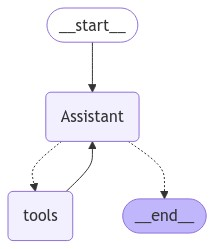

In [74]:
from IPython.display import display, Image
display(Image(zero_shot_graph.get_graph().draw_mermaid_png()))

**Example conversation:**

In [75]:
import uuid
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "Reviewer_Nationality": "Germany",
        "thread_id": thread_id,
    }
}

questions= [
    "Can you recommend me some hotels in Paris?"
    "I'd like somewhere suitable for buisness",
    "Can you recommend somewhere with a score greater than 8?"
]

In [76]:
_printed = set()
for question in questions:
    events = zero_shot_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Can you recommend me some hotels in Paris?I'd like somewhere suitable for buisness
================================== Ai Message ==================================
Tool Calls:
  Search_hotels (call_PixETxC3xUYCakN1uzMjUFHg)
 Call ID: call_PixETxC3xUYCakN1uzMjUFHg
  Args:
    Tag: business
================================= Tool Message =================================
Name: Search_hotels

[]
================================== Ai Message ==================================

I couldn't find any specific hotels in Paris suitable for business according to the current search. However, Paris is a hub for business travelers, and there are many hotels that cater to business needs. Would you like me to broaden the search to include more options or provide recommendations for popular business hotels in Paris?
================================ Human Message =================================

Can you recommend somewher